## Imports

In [2]:
import pymysql.cursors
import configparser
import sqlalchemy
import os, re

In [3]:
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, ensemble, linear_model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import OrderedDict

In [5]:
print(sklearn.__version__)
print(pd.__version__)

0.18.1
0.19.2


## Functions

### Connection functions

In [6]:
def connect_to_database(credentials_path, group):
    reader = configparser.RawConfigParser()
    reader.read(os.path.join(credentials_path, '.my.cnf'))
    connection_string = 'mysql+pymysql://{user}:{password}@{host}:{port}/{dbname}'.format(
        user = reader.get(group, 'user'),
        password = reader.get(group, 'password'),
        host = reader.get(group, 'host'),
        port = reader.get(group, 'port'),
        dbname = reader.get(group, 'database')
    )
    engine = sqlalchemy.create_engine(connection_string)
    return engine

### Data transformation functions

In [7]:
def convert_categorical(data):
    binary_cols = set(col for col in data if (data[col].nunique() == 2 and not col.endswith('counts')))
    string_cols = set(col for col in data if data[col].dtype == 'O')
    categoricals = binary_cols.union(string_cols)
    categoricals.add('appl_year')
    data_categorical = data.astype({col: 'category' for col in categoricals})
    return data_categorical

In [8]:
def get_data_for_modeling(engine, tbl_name):
    get_table = 'select * from deidentified$model_data${}'.format(tbl_name)
    model_matrix = pd.read_sql_query(get_table, engine)
    model_matrix = model_matrix.set_index('study_id')
    model_matrix = model_matrix.astype({'appl_year': int})
    model_matrix = convert_categorical(model_matrix)
    return model_matrix

In [9]:
def split_data(model_matrix, seed = 1100):
    X, y = model_matrix.drop('outcome', axis = 1), model_matrix.outcome
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size = 0.20, random_state = seed)
    y_train, y_test = y_train.astype(int), y_test.astype(int)
    return X_train, X_test, y_train, y_test

### Pipeline functions

In [10]:
def extract_step_from_pipeline(cv_pipeline, step_name):
    return cv_pipeline.best_estimator_.named_steps.get(step_name)

In [11]:
def describe_pipeline_steps(cv_pipeline):
    return cv_pipeline.best_estimator_.named_steps.keys()

In [12]:
def extract_model_from_pipeline(cv_pipeline):
    steps = describe_pipeline_steps(cv_pipeline)
    pattern = "(classifier|regressor)$"
    prog = re.compile(pattern)
    model_step = [step for step in steps if bool(prog.search(step))]
    return extract_step_from_pipeline(cv_pipeline, model_step[-1])

In [13]:
def get_transformed_columns(cv_pipeline, encoder_step, data):
    return extract_step_from_pipeline(cv_pipeline, encoder_step).transform(data).columns

### Plotting and reporting functions

In [14]:
def get_results(true, pred_prob, X):
    true_vs_pred = list(zip(true, pred_prob))
    results = pd.DataFrame(true_vs_pred, 
                           columns = ["true", "predicted probability"], index = X.index)
    return results

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
def build_and_plot_confusion_matrix(true, predicted, class_names, model_name):
    # Compute confusion matrix
    class_names = ['not AOA', 'AOA']
    cnf_matrix = confusion_matrix(true, predicted)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, 
                          classes = class_names,
                          title = model_name)

In [17]:
def compute_feature_importances_ensemble(clf, transformed_columns):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    n_cols = len(transformed_columns)

    # Print the feature ranking
    print("Feature ranking:")
    labeled_importances = OrderedDict(zip(
        transformed_columns[indices], importances[indices]))

    for feature, score in labeled_importances.items():
        print("%s: (%f)" % (feature, score))
    
    return importances, std, indices

In [18]:
def plot_feature_importances(importances, std, indices, transformed_columns, top_n = 15):
    top_n_indices = indices[:top_n]
    plt.title("Feature importances")
    plt.bar(range(top_n), importances[top_n_indices],
       color="r", yerr=std[top_n_indices], align="center")
    plt.xticks(range(top_n), transformed_columns[top_n_indices], rotation = 90)
    plt.xlim([-1, top_n])
    plt.show()

In [19]:
def generate_binary_at_k(y_scores, k):
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

def precision_at_k(y_true, y_scores, k):
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = precision_score(y_true, preds_at_k)
    return precision

In [20]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])

    plt.title(model_name)
    plt.show()

In [21]:
def plot_pr_curve(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    auc = sklearn.metrics.roc_auc_score(y_true, y_prob)

    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall {}: AUC={:0.2f}'.format(model_name, auc))
    plt.legend(loc="lower right")
    plt.show()

## Custom transformers and scorers

In [22]:
class DummyEncoder(sklearn.base.BaseEstimator, TransformerMixin):

    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, y=None, **kwargs):
        return pd.get_dummies(X, columns = self.columns, 
            drop_first = True, dummy_na = True)

    def fit(self, X, y=None, **kwargs):
        return self

## Connect to database

In [23]:
group = 'edu_db_owner'
credentials_path = '/Volumes/IIME/EDS/data/admissions/db_credentials'

engine = connect_to_database(credentials_path, group)

In [24]:
# tbl_name = 'grades_gpa_mcat_other_features'
tbl_name = 'grades_gpa_mcat_medschool'
model_matrix = get_data_for_modeling(engine, tbl_name)

In [25]:
model_matrix.shape

(1218, 60)

## Prepare data for modeling

In [26]:
X_train, X_test, y_train, y_test = split_data(model_matrix)

In [27]:
param_grid = dict(
    imputer__strategy= ['mean', 'median'],
    randomforestclassifier__n_estimators= [10, 50, 100, 200, 500, 1000],
    randomforestclassifier__max_depth= [1, 5, 10, 20, 50],
    randomforestclassifier__max_features= ['sqrt', 'log2'],
    randomforestclassifier__min_samples_split= [2, 5, 10])

In [28]:
pipeline = make_pipeline(DummyEncoder(), 
                         preprocessing.Imputer(), 
                         ensemble.RandomForestClassifier(random_state = 1100))

In [134]:
# grid_search = GridSearchCV(pipeline, cv = 5, param_grid = param_grid, 
#                           scoring = 'recall')

In [29]:
grid_search_auc = GridSearchCV(pipeline, cv = 5, param_grid = param_grid, 
                               scoring = 'roc_auc')

In [ ]:
grid_search_auc.fit(X_train, y_train)

In [419]:
risk_scores = grid_search_auc.predict_proba( X_test )
hard_predictions = grid_search_auc.predict( X_test )

In [184]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

0    825
1    149
dtype: int64
0    202
1     42
dtype: int64


974 students in the training set 
- 825 not AOA
- 149 AOA

244 students in the test set
- 202 not AOA
- 42 AOA

In [420]:
get_results(y_test, risk_scores[:, 1], X_test)

,true,predicted probability
study_id,,
a2b69ab1223b67c58aea757c6c7d1da5,0,0.192153
a44658486e4709986109c4d083fc2910,0,0.180030
49d1a1ac19aa5c0825003fd934be0a73,0,0.192153
753ce5f108806745c6f57a2f9e599479,0,0.145145
a22bcffb888ffd75feefc7a54e289c30,0,0.124544
1160377770e2d2aa893044b9e95d8231,0,0.152129
c2a6a067f480433b18489914bf3231f8,0,0.173615
20c17adabd62b2e4776f3f7a285a5583,0,0.136440
1f512f3048c6323922763e57df395655,0,0.146334


In [421]:
hard_predictions_15_pct = generate_binary_at_k(risk_scores, 15)
hard_predictions_20_pct = generate_binary_at_k(risk_scores, 20)

Confusion matrix, without normalization
[[202   0]
 [ 42   0]]
Confusion matrix, without normalization
[[171  31]
 [ 37   5]]
Confusion matrix, without normalization
[[162  40]
 [ 34   8]]


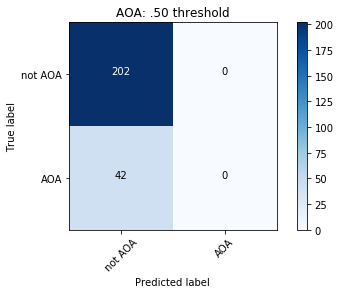

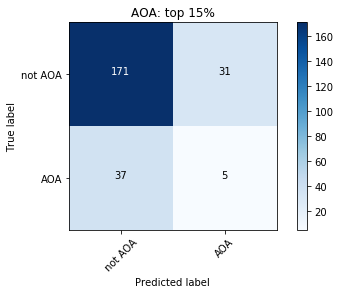

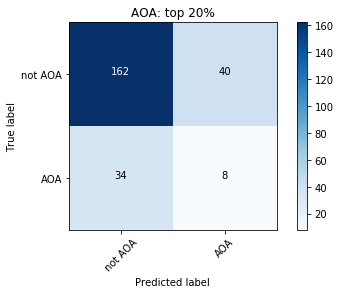

In [422]:
# Compute confusion matrix
class_names = ['not AOA', 'AOA']

# Plot confusion matrix with counts
plt.figure()
build_and_plot_confusion_matrix(
    y_test, hard_predictions,
    class_names, 'AOA: .50 threshold')

plt.figure()
build_and_plot_confusion_matrix(
    y_test, hard_predictions_15_pct,
    class_names, 'AOA: top 15%')

plt.figure()
build_and_plot_confusion_matrix(
    y_test, hard_predictions_20_pct,
    class_names, 'AOA: top 20%')
plt.show()

In [371]:
print(describe_pipeline_steps(grid_search_auc))
forest = extract_model_from_pipeline(grid_search_auc)
print(type(forest))

dict_keys(['dummyencoder', 'imputer', 'randomforestclassifier'])
<class 'sklearn.ensemble.forest.RandomForestClassifier'>


In [380]:
transformed_columns = get_transformed_columns(grid_search_auc, 'dummyencoder', X_train)

In [394]:
importances, std, indices = compute_feature_importances_ensemble(forest, transformed_columns)

Feature ranking:
bcpm_hours_cumulative: (0.066737)
total_percentile: (0.057606)
total_num_schools_accepted_to: (0.057032)
total_gpa_cumulative: (0.055307)
bcpm_gpa_cumulative: (0.055215)
bcpm_a_counts: (0.054110)
bio_percentile: (0.052587)
chem_a_counts: (0.047795)
phy_chem_percentile: (0.040989)
biol_a_counts: (0.040720)
age_at_application: (0.037391)
bcpm_b_counts: (0.034002)
math_a_counts: (0.033703)
race_White: (0.025710)
phys_a_counts: (0.024174)
chem_b_counts: (0.019437)
biol_b_counts: (0.018897)
bcmp_gpa_seni_higher_nan: (0.017385)
gender_M: (0.016584)
bcmp_gpa_juni_higher_1.0: (0.014806)
math_b_counts: (0.014593)
appl_year_2007.0: (0.013911)
college_top_25_1.0: (0.013484)
total_gpa_juni_higher_1.0: (0.013376)
phys_b_counts: (0.012537)
total_gpa_soph_higher_1.0: (0.010572)
total_gpa_postbac: (0.009973)
total_gpa_seni_higher_nan: (0.008650)
appl_year_2013.0: (0.008210)
appl_year_2011.0: (0.008191)
appl_year_2009.0: (0.007533)
appl_year_2012.0: (0.007482)
race_Chinese: (0.007439)


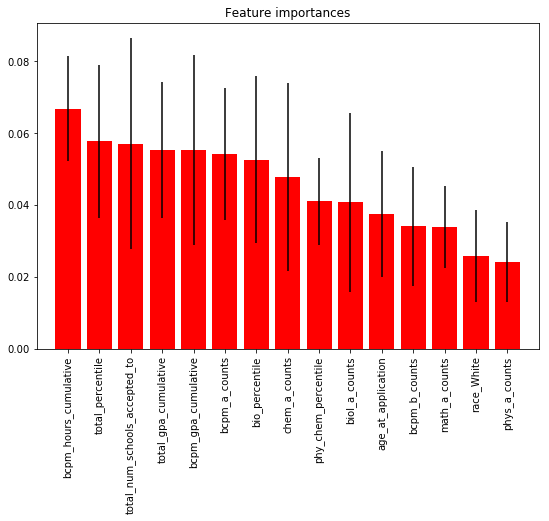

In [402]:
# Plot the feature importances of the forest
plt.figure(figsize=(9,6))
plot_feature_importances(importances, std, indices, transformed_columns)

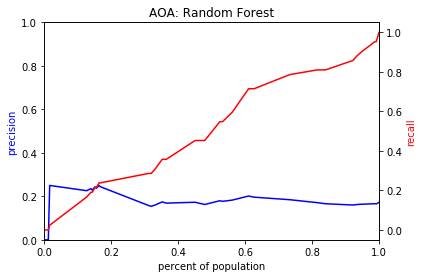

In [409]:
plot_precision_recall_n(y_test, risk_scores[:,1], 'AOA: Random Forest')

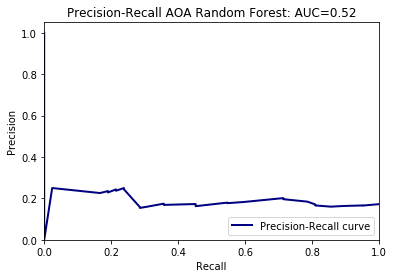

In [414]:
plot_pr_curve(y_test, risk_scores[:,1], 'AOA Random Forest')

In [ ]:
# TODO: Multiclass classification
# TODO: Compare classifiers (logistic regression?)
# TODO: Incorporate lime
# TODO: Incorporate autosklearn?